# P-210 Fake Bills Detection

# Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold

from sklearn import svm
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier


from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install xgboost

# Data Import

In [3]:
raw_data = pd.read_excel("fake_bills.xlsx")


In [4]:
raw_data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [5]:
raw_data.duplicated().sum()

0

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


# Data Manipulation

In [7]:
raw_data.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [8]:
raw_data["margin_low"].isnull().mean()*100

2.466666666666667

In [9]:
print('mean :' , raw_data["margin_low"].mean())
print('median :' , raw_data["margin_low"].median())

mean : 4.485967190704034
median : 4.31


<AxesSubplot:xlabel='margin_low'>

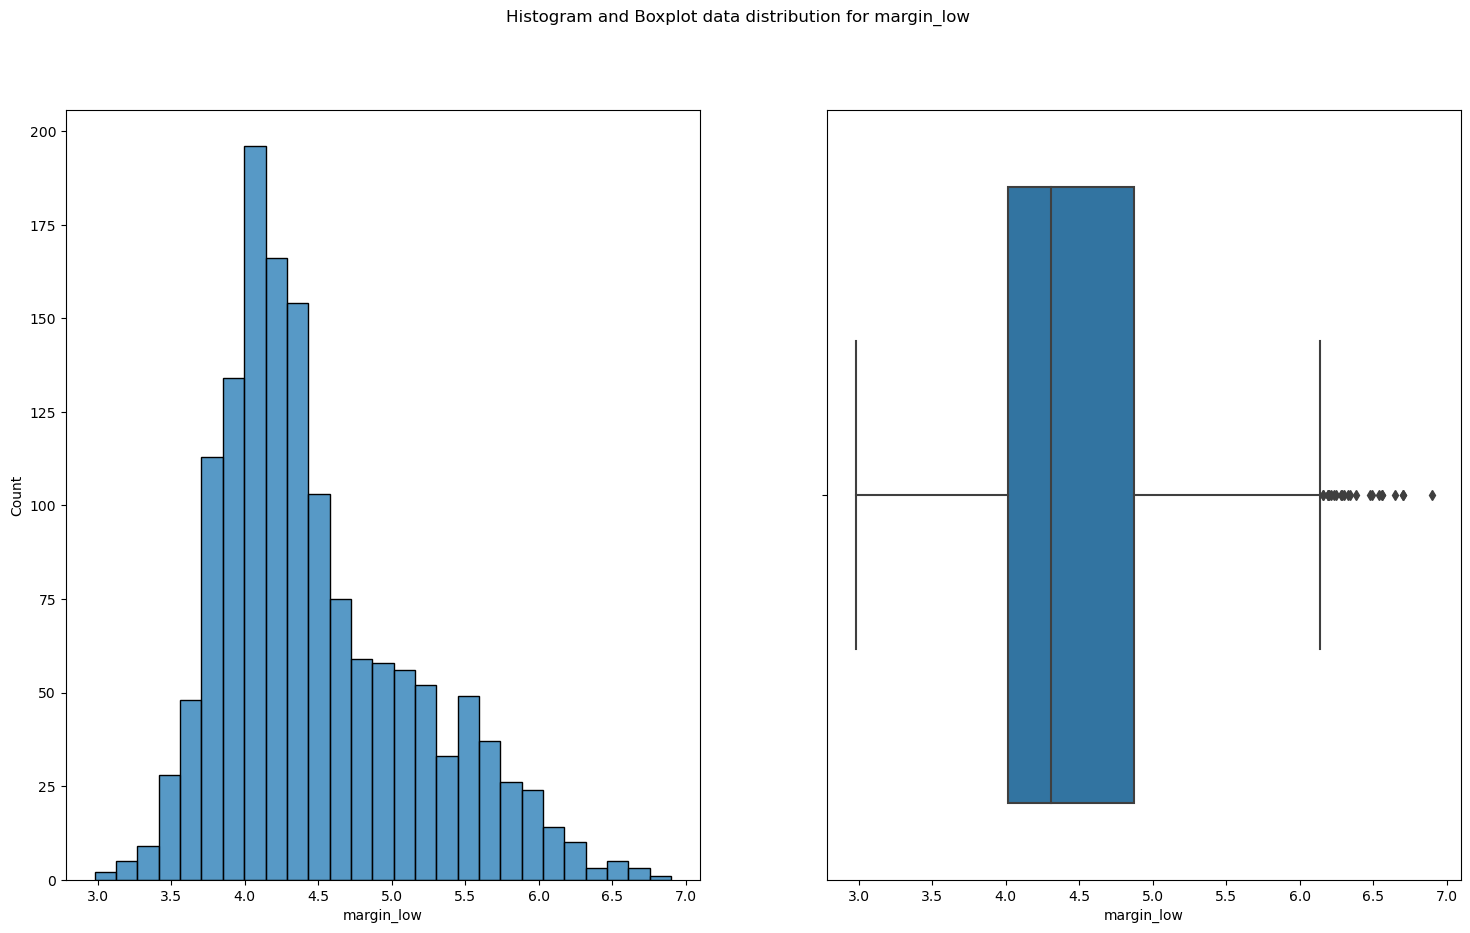

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Histogram and Boxplot data distribution for margin_low ')
sns.histplot(ax=axes[0], x=raw_data["margin_low"])
sns.boxplot(ax=axes[1], x=raw_data["margin_low"])

# sns.boxplot(x=raw_data["margin_low"])
# sns.displot( x=raw_data["margin_low"])

In [11]:
data = raw_data.fillna(raw_data.median())

In [12]:
data.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

# Data Analysis

## Univariate

In [13]:
data.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.481627,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.656137,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.030000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.860000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [14]:
data["is_genuine"].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

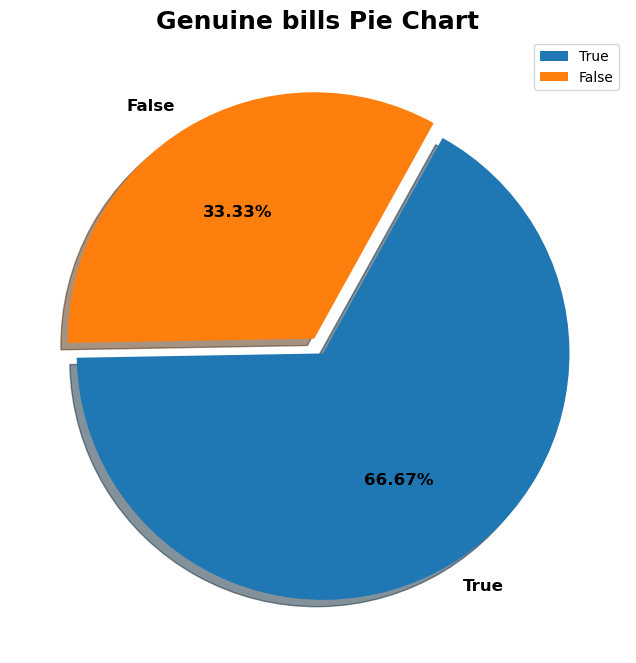

In [15]:
plt.figure(figsize = (12,8))
plt.pie(data["is_genuine"].value_counts(),
       labels=data["is_genuine"].unique(),
       explode = [0.04,0.03],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 181,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'horizontal',
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Genuine bills Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

# fig = go.Figure(data=[go.Pie(labels=data["is_genuine"].unique(),
#                              values=data["is_genuine"].value_counts(),
#                              pull=[0.2, 0],
#                              title='Genuine bills Pie Chart')])
# fig.update_layout(autosize=False,width=500,height=500)
# fig.show()

# sns.countplot(x=data["is_genuine"])

# fig, ax = plt.subplots()
# ax = sns.countplot(x=data["is_genuine"])
# ax.bar_label(ax.containers[0], label_type='edge')

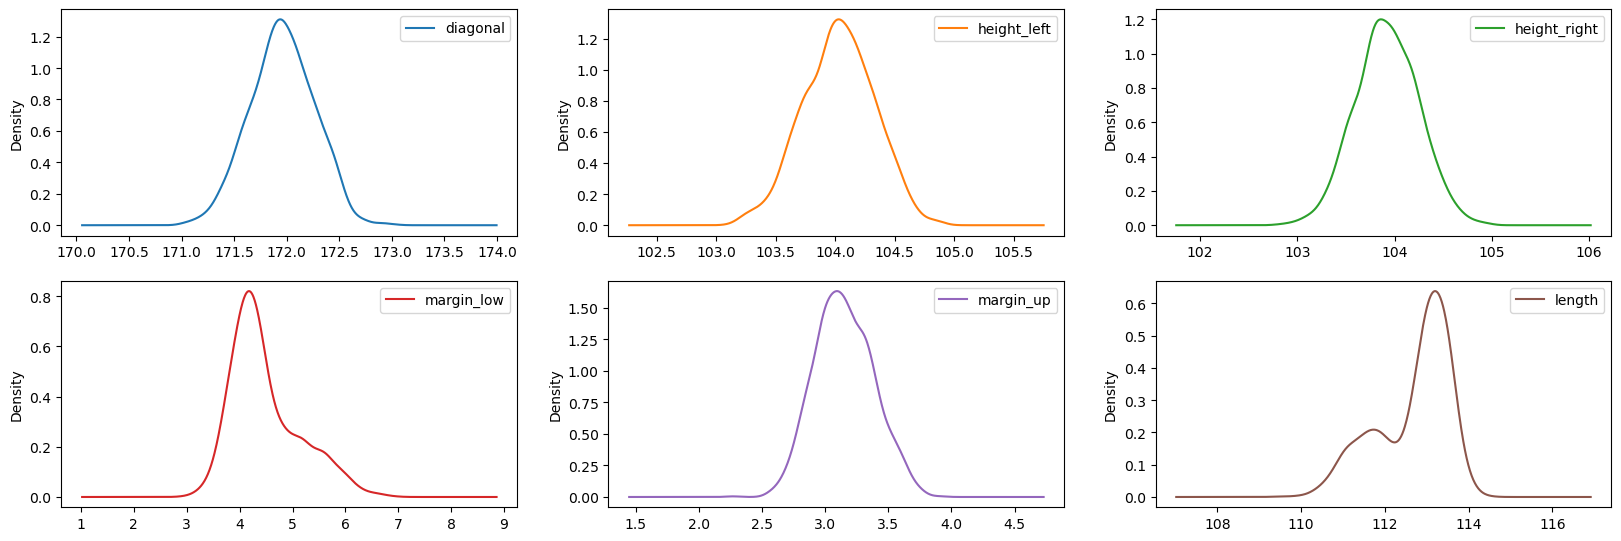

In [16]:
# for n in data.columns:
#     print(n)
#     plt.figure(figsize=(5,5))
#     sns.kdeplot(data[n])
#     plt.show()

# density
data.plot(kind='density',
             figsize=(20, 10),
             subplots=True,
             layout=(3, 3),
             sharex=False,
             legend=True)
plt.show()

diagonal


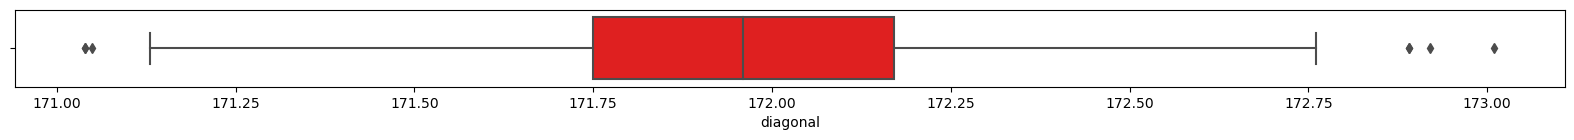

height_left


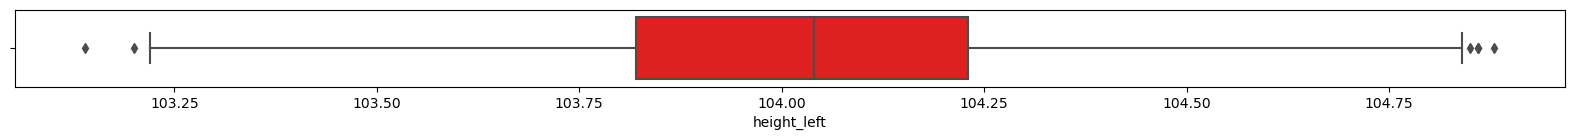

height_right


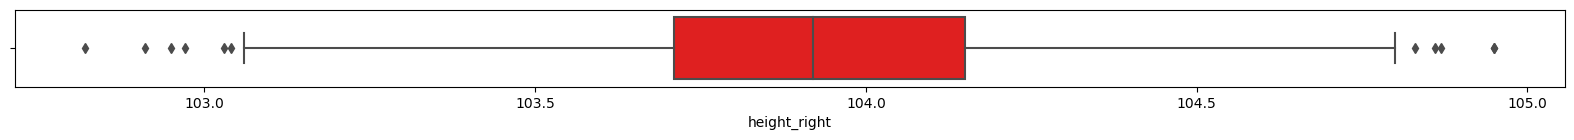

margin_low


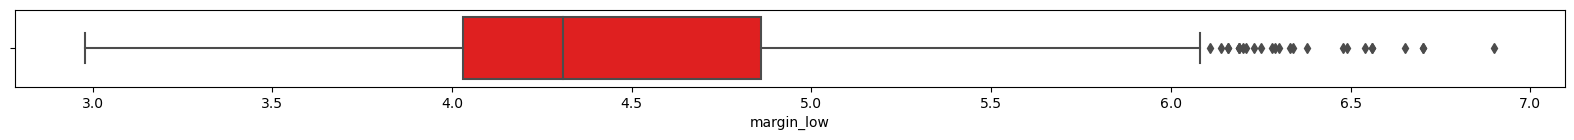

margin_up


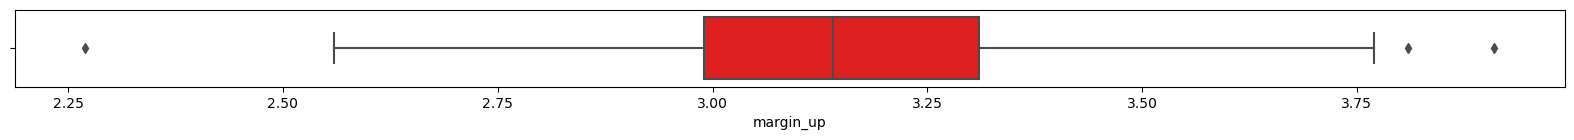

length


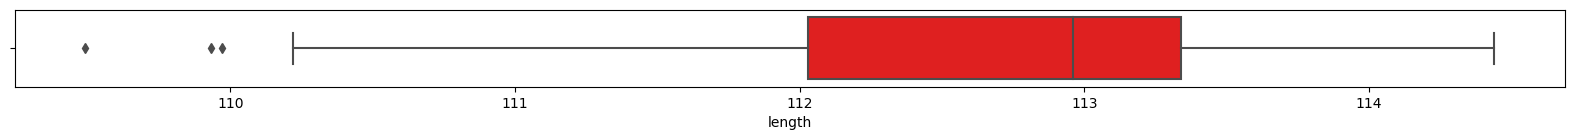

In [17]:
for n in data.columns[1:]:
    print(n)
    plt.figure(figsize=(20,1))
    sns.boxplot(data[n], orient="h", color='red')
    plt.show()

In [18]:
# data.iloc[:,1:]

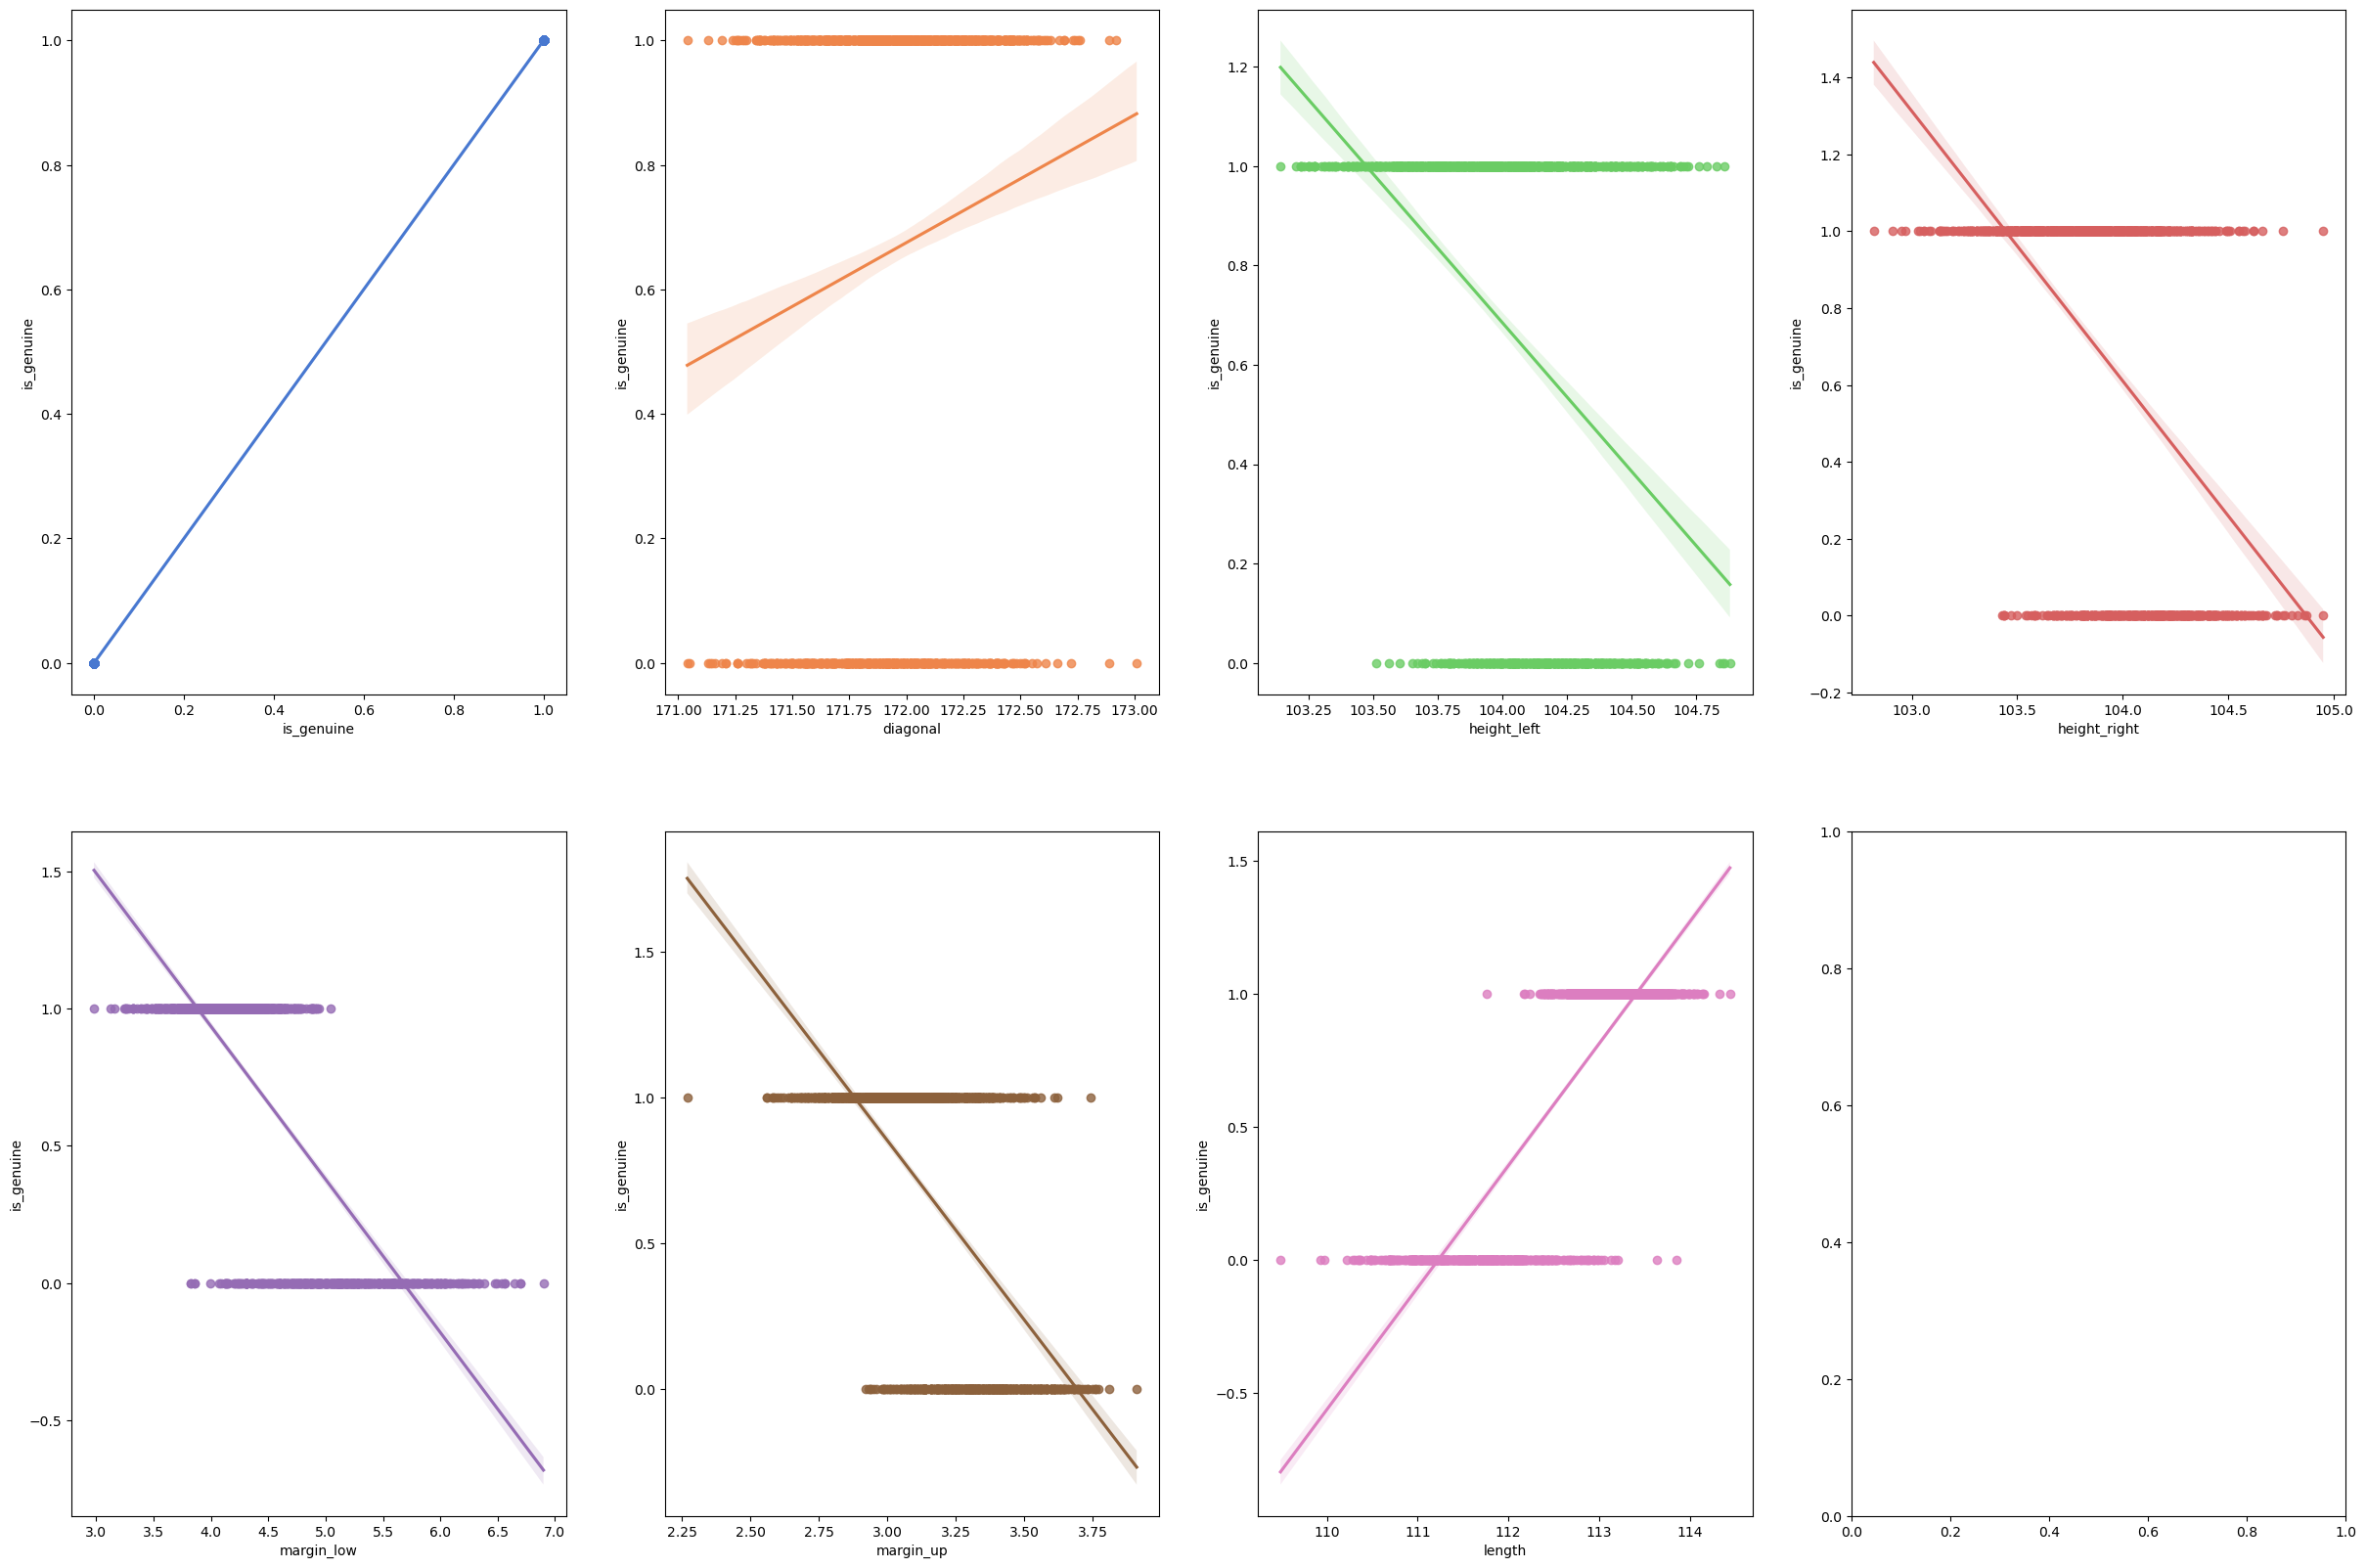

In [19]:
fig, axes = plt.subplots(2,4,figsize=(30,20))
axe = axes.flatten()
color_palette = sns.color_palette("muted") + sns.color_palette("Set2") + sns.color_palette("husl", 25)

for i,feature in enumerate(data):
    sns.regplot(data=data, x=feature, y="is_genuine", color=color_palette[i], ax=axe[i])
plt.show()

## Bivariate

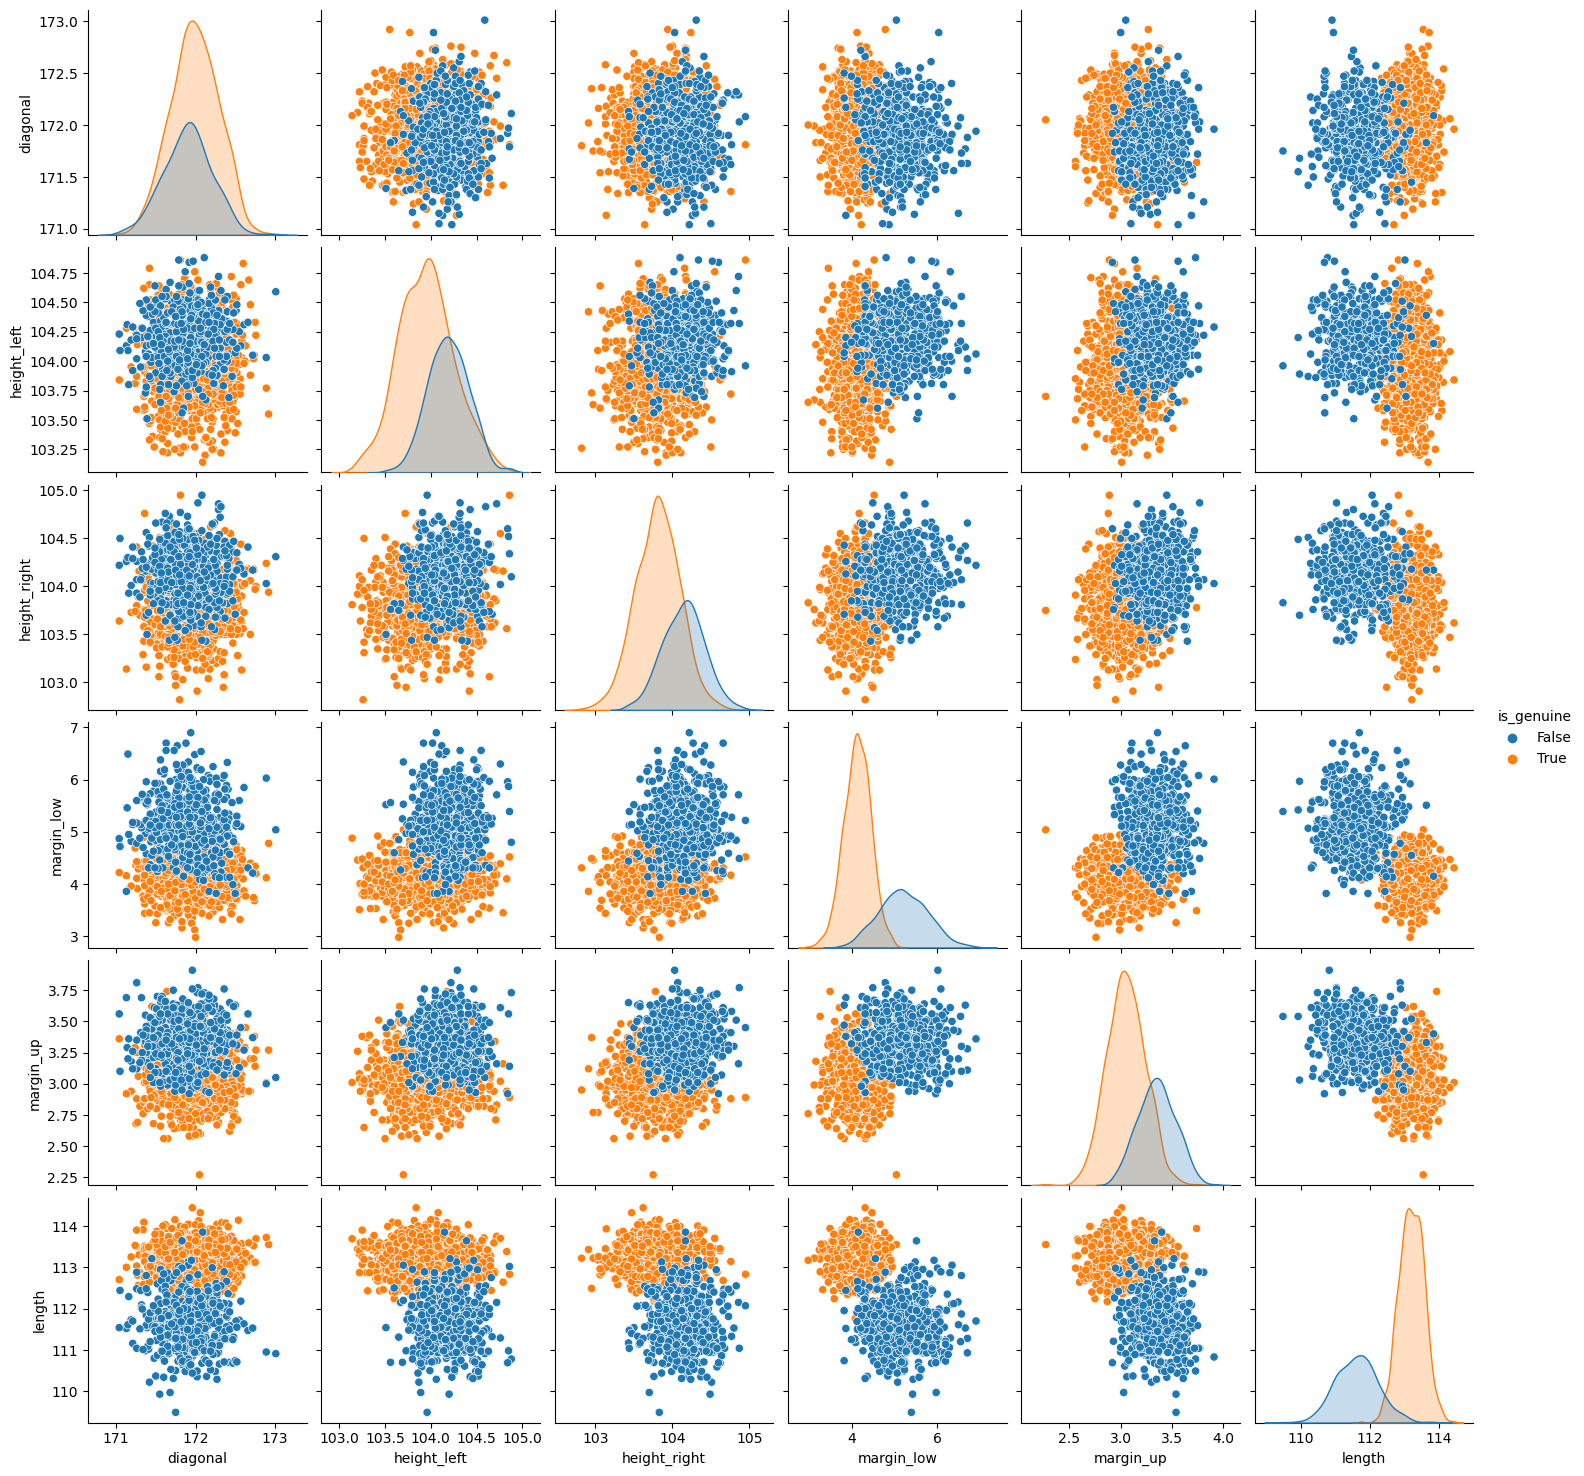

In [20]:
sns.pairplot(data=data, hue="is_genuine")

In [21]:
data.corr().style.background_gradient(cmap='coolwarm')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.775988,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.109502,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.300342,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.385121,0.307005,-0.401751
margin_low,-0.775988,-0.109502,0.300342,0.385121,1.000000,0.427056,-0.659396
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.427056,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.659396,-0.520575,1.000000


In [22]:
data.corr()["is_genuine"].sort_values(ascending=False)

is_genuine      1.000000
length          0.849285
diagonal        0.132756
height_left    -0.379833
height_right   -0.485092
margin_up      -0.606262
margin_low     -0.775988
Name: is_genuine, dtype: float64

<AxesSubplot:xlabel='height_left', ylabel='height_right'>

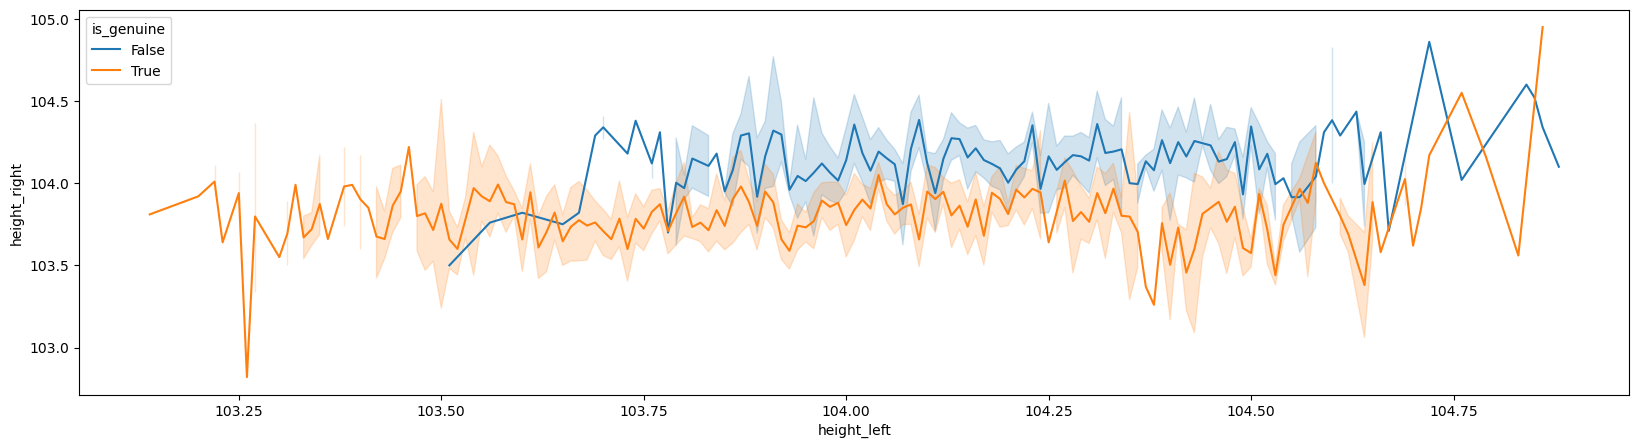

In [23]:
plt.figure(figsize=(20,5))
sns.lineplot(data=data, x="height_left", y="height_right", hue="is_genuine", legend='auto')

<AxesSubplot:xlabel='diagonal', ylabel='length'>

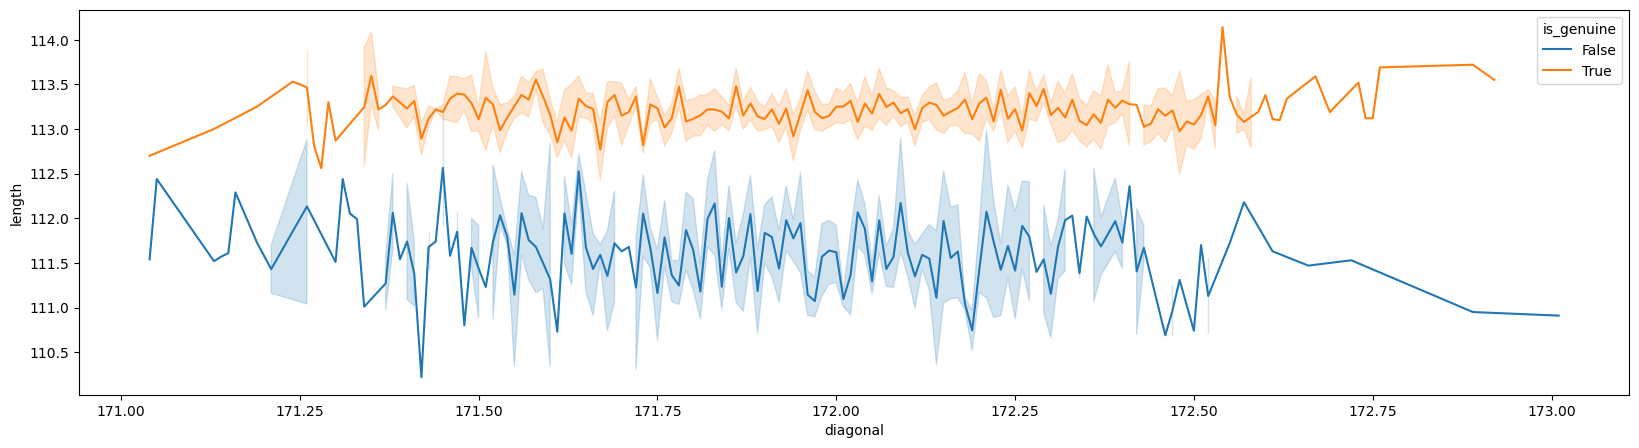

In [24]:
plt.figure(figsize=(20,5))
sns.lineplot(data=data, x="diagonal", y="length", hue="is_genuine", legend='auto')

<AxesSubplot:xlabel='margin_low', ylabel='margin_up'>

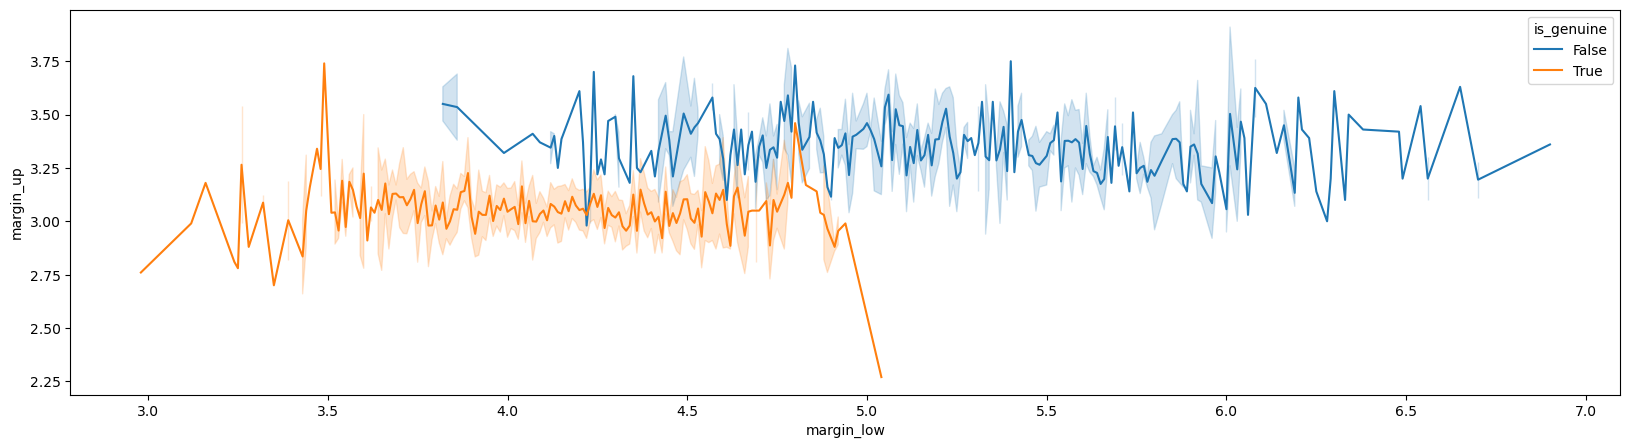

In [25]:
plt.figure(figsize=(20,5))
sns.lineplot(data=data, x="margin_low", y="margin_up", hue ="is_genuine", legend='auto')

# Model Building

## Label Encoding

In [26]:
df = data.copy()

label_encoder = preprocessing.LabelEncoder()
df['is_genuine']= label_encoder.fit_transform(df['is_genuine'])
  
print(df['is_genuine'].unique())
df.head()

[1 0]


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [27]:
X = df.drop(['is_genuine'], axis=1)
Y = df['is_genuine']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.30, random_state =7, stratify=Y)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1050, 6), (450, 6), (1050,), (450,))

In [28]:
print("Y_train: \n",Y_train.value_counts())
print("Y_test: \n",Y_test.value_counts())

Y_train: 
 1    700
0    350
Name: is_genuine, dtype: int64
Y_test: 
 1    300
0    150
Name: is_genuine, dtype: int64


In [29]:
#We are going to append all models and evaluation scores to results_df
results_df = pd.DataFrame(columns=['Model', 'Accuracy_train', 'Accuracy_test', 'F1_Score', 'ROC_AUC'])

## Logistic Classifier

In [30]:
model = "Logistic Classifier"

clf_log = LogisticRegression(random_state=7)
clf_log.fit(X_train, Y_train)
Y_pred_log = clf_log.predict(X_test)
Y_pred_train_log = clf_log.predict(X_train)

accuracy_train = metrics.accuracy_score(Y_train, Y_pred_train_log)*100
print("Accuracy_train:", accuracy_train)
accuracy_test = metrics.accuracy_score(Y_test, Y_pred_log)*100
print("Accuracy_test:", accuracy_test)
f1 = f1_score(Y_test, Y_pred_log)
auc = roc_auc_score(Y_test, Y_pred_log)
print("ROC_AUC:", auc)
print(confusion_matrix(Y_test, Y_pred_log))
print(classification_report(Y_test, Y_pred_log))

Accuracy_train: 99.42857142857143
Accuracy_test: 98.0
ROC_AUC: 0.975
[[144   6]
 [  3 297]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       150
           1       0.98      0.99      0.99       300

    accuracy                           0.98       450
   macro avg       0.98      0.97      0.98       450
weighted avg       0.98      0.98      0.98       450



In [31]:
results_df = results_df.append({'Model': model, 'Accuracy_train': accuracy_train, 'Accuracy_test': accuracy_test, 
                                'F1_Score': f1*100, 'ROC_AUC': auc*100}, ignore_index=True)
results_df

,Model,Accuracy_train,Accuracy_test,F1_Score,ROC_AUC
0,Logistic Classifier,99.428571,98.0,98.507463,97.5


## Naive Bayes

In [32]:
model = "Naive Bayes"

clf_nb = GaussianNB()
clf_nb.fit(X_train, Y_train)
Y_pred_nb = clf_nb.predict(X_test)
Y_pred_train_nb= clf_nb.predict(X_train)

accuracy_train = metrics.accuracy_score(Y_train, Y_pred_train_nb)*100
print("Accuracy_train:", accuracy_train)
accuracy_test = metrics.accuracy_score(Y_test, Y_pred_nb)*100
print("Accuracy_test:", accuracy_test)
f1 = f1_score(Y_test, Y_pred_nb)
auc = roc_auc_score(Y_test, Y_pred_nb)
print("ROC_AUC:", auc)
print(confusion_matrix(Y_test, Y_pred_nb))
print(classification_report(Y_test, Y_pred_nb))

Accuracy_train: 99.42857142857143
Accuracy_test: 98.44444444444444
ROC_AUC: 0.9799999999999999
[[145   5]
 [  2 298]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       0.98      0.99      0.99       300

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [33]:
results_df = results_df.append({'Model': model, 'Accuracy_train': accuracy_train, 'Accuracy_test': accuracy_test, 
                                'F1_Score': f1*100, 'ROC_AUC': auc*100}, ignore_index=True)
results_df

,Model,Accuracy_train,Accuracy_test,F1_Score,ROC_AUC
0,Logistic Classifier,99.428571,98.000000,98.507463,97.5
1,Naive Bayes,99.428571,98.444444,98.839138,98.0


## SVM

In [34]:
model = "Support Vector Machine"

clf_svc = svm.SVC(C= 0.1, gamma=0.0001, kernel= 'linear')
clf_svc.fit(X_train , Y_train)
Y_pred_svc = clf_svc.predict(X_test)
Y_pred_train_svc= clf_svc.predict(X_train)

accuracy_train = metrics.accuracy_score(Y_train, Y_pred_train_svc)*100
print("Accuracy_train:", accuracy_train)
accuracy_test = metrics.accuracy_score(Y_test, Y_pred_svc)*100
print("Accuracy_test:", accuracy_test)
f1 = f1_score(Y_test, Y_pred_svc)
auc = roc_auc_score(Y_test, Y_pred_svc)
print("ROC_AUC:", auc)
print(confusion_matrix(Y_test, Y_pred_svc))
print(classification_report(Y_test, Y_pred_svc))

Accuracy_train: 99.33333333333333
Accuracy_test: 98.22222222222223
ROC_AUC: 0.9766666666666666
[[144   6]
 [  2 298]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       150
           1       0.98      0.99      0.99       300

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [35]:
results_df = results_df.append({'Model': model, 'Accuracy_train': accuracy_train, 'Accuracy_test': accuracy_test, 
                                'F1_Score': f1*100, 'ROC_AUC': auc*100}, ignore_index=True)
results_df

,Model,Accuracy_train,Accuracy_test,F1_Score,ROC_AUC
0,Logistic Classifier,99.428571,98.000000,98.507463,97.500000
1,Naive Bayes,99.428571,98.444444,98.839138,98.000000
2,Support Vector Machine,99.333333,98.222222,98.675497,97.666667


In [36]:
sc_X = StandardScaler()

X_train_sc = sc_X.fit_transform(X_train)
X_test_sc = sc_X.transform(X_test)

In [37]:
classifier = svm.SVC()
seed = 7
num_folds = 10
scoring = 'accuracy'
kfold = KFold(n_splits=num_folds, random_state=None)

c_values = [0.1, 0.3, 0.5]
g_values = [0.0001, 0.001, 0.01]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(kernel=kernel_values, C=c_values, gamma=g_values )

grid_cv_svc = GridSearchCV(estimator=classifier,
                        param_grid=param_grid,
                        scoring=scoring,
                        cv=kfold, 
                        verbose=1)

grid_cv_svc.fit(X_train_sc, Y_train)
print("Best score is: %f using %s" % (grid_cv_svc.best_score_*100, 
                                      grid_cv_svc.best_params_))

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best score is: 99.428571 using {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}


In [38]:
model = "Support Vector Machine SC"

clf_svc_sc = svm.SVC(C= 0.1, gamma=0.0001, kernel= 'linear')
clf_svc_sc.fit(X_train_sc , Y_train)
Y_pred_svc_sc = clf_svc_sc.predict(X_test_sc)
Y_pred_train_svc_sc= clf_svc_sc.predict(X_train_sc)

accuracy_train = metrics.accuracy_score(Y_train, Y_pred_train_svc_sc)*100
print("Accuracy_train:", accuracy_train)
accuracy_test = metrics.accuracy_score(Y_test, Y_pred_svc_sc)*100
print("Accuracy_test:", accuracy_test)
f1 = f1_score(Y_test, Y_pred_svc_sc)
auc = roc_auc_score(Y_test, Y_pred_svc_sc)
print("ROC_AUC:", auc)
print(confusion_matrix(Y_test, Y_pred_svc_sc))
print(classification_report(Y_test, Y_pred_svc_sc))

Accuracy_train: 99.52380952380952
Accuracy_test: 98.22222222222223
ROC_AUC: 0.9783333333333333
[[145   5]
 [  3 297]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       150
           1       0.98      0.99      0.99       300

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [39]:
results_df = results_df.append({'Model': model, 'Accuracy_train': accuracy_train, 'Accuracy_test': accuracy_test, 
                                'F1_Score': f1*100, 'ROC_AUC': auc*100}, ignore_index=True)
results_df

,Model,Accuracy_train,Accuracy_test,F1_Score,ROC_AUC
0,Logistic Classifier,99.428571,98.000000,98.507463,97.500000
1,Naive Bayes,99.428571,98.444444,98.839138,98.000000
2,Support Vector Machine,99.333333,98.222222,98.675497,97.666667
3,Support Vector Machine SC,99.523810,98.222222,98.671096,97.833333


## KNN

In [40]:
model = "K-Nearest Neighbour"

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train , Y_train)
Y_pred_knn = clf_knn.predict(X_test)
Y_pred_train_knn= clf_knn.predict(X_train)

accuracy_train = metrics.accuracy_score(Y_train, Y_pred_train_knn)*100
print("Accuracy_train:", accuracy_train)
accuracy_test = metrics.accuracy_score(Y_test, Y_pred_knn)*100
print("Accuracy_test:", accuracy_test)
f1 = f1_score(Y_test, Y_pred_knn)
auc = roc_auc_score(Y_test, Y_pred_knn)
print("ROC_AUC:", auc)
print(confusion_matrix(Y_test, Y_pred_knn))
print(classification_report(Y_test, Y_pred_knn))

Accuracy_train: 99.42857142857143
Accuracy_test: 98.44444444444444
ROC_AUC: 0.9799999999999999
[[145   5]
 [  2 298]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       0.98      0.99      0.99       300

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [41]:
results_df = results_df.append({'Model': model, 'Accuracy_train': accuracy_train, 'Accuracy_test': accuracy_test, 
                                'F1_Score': f1*100, 'ROC_AUC': auc*100}, ignore_index=True)
results_df

,Model,Accuracy_train,Accuracy_test,F1_Score,ROC_AUC
0,Logistic Classifier,99.428571,98.000000,98.507463,97.500000
1,Naive Bayes,99.428571,98.444444,98.839138,98.000000
2,Support Vector Machine,99.333333,98.222222,98.675497,97.666667
3,Support Vector Machine SC,99.523810,98.222222,98.671096,97.833333
4,K-Nearest Neighbour,99.428571,98.444444,98.839138,98.000000


## Decision Tree

In [42]:
# grid_dt = { 
#     'max_features': ['sqrt', 'log2', 'auto'],
#     'criterion' :['gini', 'entropy'],
#     "splitter":("best", "random"), 
#     "max_depth":(list(range(1, 16))), 
#     "min_samples_split":[2, 3, 4, 5, 10, 15, 20, 50, 100], 
#     "min_samples_leaf":list(range(1, 6))
# }

# clf_dt = DecisionTreeClassifier(random_state=7)
# grid_cv_dt = GridSearchCV(estimator=clf_dt, 
#                           param_grid=grid_dt, 
#                           scoring="accuracy", 
#                           n_jobs=-1, 
#                           verbose=1, 
#                           cv=10)

# grid_cv_dt.fit(X_train, Y_train)
# print("Best score is: %f using %s" % (grid_cv_dt.best_score_*100, 
#                                       grid_cv_dt.best_params_))

In [43]:
model = "Decision Tree"

clf_dt = DecisionTreeClassifier(criterion='gini', 
                                max_depth=15, 
                                min_samples_leaf=1, 
                                min_samples_split=3, 
                                splitter='random', 
                                max_features= 'sqrt')
clf_dt.fit(X_train , Y_train)
Y_pred_dt = clf_dt.predict(X_test)
Y_pred_train_dt = clf_dt.predict(X_train)

accuracy_train = metrics.accuracy_score(Y_train, Y_pred_train_dt)*100
print("Accuracy_train:", accuracy_train)
accuracy_test = metrics.accuracy_score(Y_test, Y_pred_dt)*100
print("Accuracy_test:", accuracy_test)
f1 = f1_score(Y_test, Y_pred_dt)
auc = roc_auc_score(Y_test, Y_pred_dt)
print("ROC_AUC:", auc)
print(confusion_matrix(Y_test, Y_pred_dt))
print(classification_report(Y_test, Y_pred_dt))

Accuracy_train: 99.23809523809524
Accuracy_test: 96.66666666666667
ROC_AUC: 0.9633333333333334
[[143   7]
 [  8 292]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       150
           1       0.98      0.97      0.97       300

    accuracy                           0.97       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.97      0.97      0.97       450



In [44]:
results_df = results_df.append({'Model': model, 'Accuracy_train': accuracy_train, 'Accuracy_test': accuracy_test, 
                                'F1_Score': f1*100, 'ROC_AUC': auc*100}, ignore_index=True)
results_df

,Model,Accuracy_train,Accuracy_test,F1_Score,ROC_AUC
0,Logistic Classifier,99.428571,98.000000,98.507463,97.500000
1,Naive Bayes,99.428571,98.444444,98.839138,98.000000
2,Support Vector Machine,99.333333,98.222222,98.675497,97.666667
3,Support Vector Machine SC,99.523810,98.222222,98.671096,97.833333
4,K-Nearest Neighbour,99.428571,98.444444,98.839138,98.000000
5,Decision Tree,99.238095,96.666667,97.495826,96.333333


## Random Forest

In [45]:
# grid_rf = {
#     'n_estimators': [int(x) for x in np.linspace(start=100, stop=500, num=10)],
#     'max_features': ['sqrt', 'log2', 'auto'],
#     'max_depth' : [int(x) for x in np.linspace(4, 8, num=1)],
#     'criterion' :['gini', 'entropy'],
#     'min_samples_split' : [2, 5, 10],
#     'min_samples_leaf' : [1, 2, 4],
#     # 'bootstrap' : [True, False],
# }

# clf_rf = RandomForestClassifier(random_state=7)
# grid_cv_rf = GridSearchCV(clf_rf, grid_rf, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
# grid_cv_rf.fit(X_train, Y_train)
# best_params = grid_cv_rf.best_params_
# print(f"Best paramters: {best_params})")

In [46]:
model = "Random Forest"

clf_rf = RandomForestClassifier(criterion='gini', 
                                max_depth=4, 
                                min_samples_leaf=1, 
                                min_samples_split=5, 
                                n_estimators=100, 
                                max_features= 'sqrt')
clf_rf.fit(X_train , Y_train)
Y_pred_rf = clf_rf.predict(X_test)
Y_pred_train_rf = clf_rf.predict(X_train)

accuracy_train = metrics.accuracy_score(Y_train, Y_pred_train_rf)*100
print("Accuracy_train:", accuracy_train)
accuracy_test = metrics.accuracy_score(Y_test, Y_pred_rf)*100
print("Accuracy_test:", accuracy_test)
f1 = f1_score(Y_test, Y_pred_rf)
auc = roc_auc_score(Y_test, Y_pred_rf)
print("ROC_AUC:", auc)
print(confusion_matrix(Y_test, Y_pred_rf))
print(classification_report(Y_test, Y_pred_rf))

Accuracy_train: 99.33333333333333
Accuracy_test: 98.66666666666667
ROC_AUC: 0.9816666666666667
[[145   5]
 [  1 299]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       0.98      1.00      0.99       300

    accuracy                           0.99       450
   macro avg       0.99      0.98      0.98       450
weighted avg       0.99      0.99      0.99       450



In [47]:
results_df = results_df.append({'Model': model, 'Accuracy_train': accuracy_train, 'Accuracy_test': accuracy_test, 
                                'F1_Score': f1*100, 'ROC_AUC': auc*100}, ignore_index=True)
results_df

,Model,Accuracy_train,Accuracy_test,F1_Score,ROC_AUC
0,Logistic Classifier,99.428571,98.000000,98.507463,97.500000
1,Naive Bayes,99.428571,98.444444,98.839138,98.000000
2,Support Vector Machine,99.333333,98.222222,98.675497,97.666667
3,Support Vector Machine SC,99.523810,98.222222,98.671096,97.833333
4,K-Nearest Neighbour,99.428571,98.444444,98.839138,98.000000
5,Decision Tree,99.238095,96.666667,97.495826,96.333333
6,Random Forest,99.333333,98.666667,99.006623,98.166667


## Stacking Classifier

>Log_Reg 99.333 (0.006)
>KNN 99.333 (0.006)
>DT_CART 98.571 (0.009)
>Naive_Bayes 99.429 (0.006)
>Stacking 99.429 (0.006)


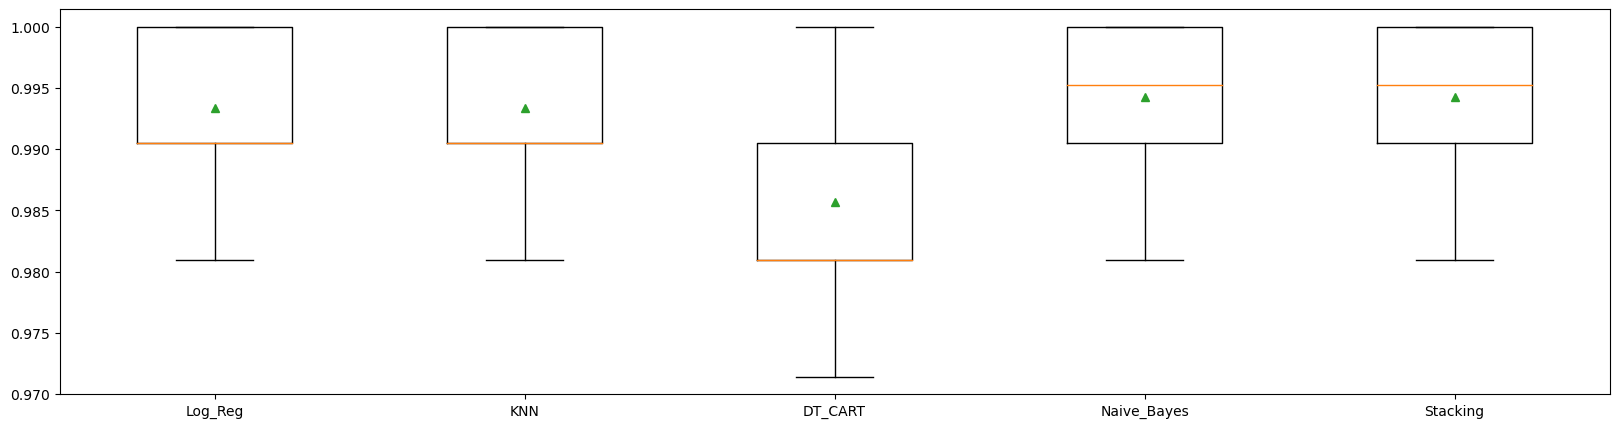

In [48]:
# get a stacking ensemble of models
def get_stacking():
 # define the base models
 level0 = list()
 level0.append(('Log_Reg', LogisticRegression()))
 level0.append(('KNN', KNeighborsClassifier()))
 level0.append(('DT_CART', DecisionTreeClassifier()))
#  level0.append(('SVM', SVC()))
 level0.append(('Naive_Bayes', GaussianNB()))
 # define meta learner model, usually by default it is log reg.
 level1 = LogisticRegression()
 # define the stacking ensemble
 model = StackingClassifier(estimators=level0, final_estimator=level1, cv=10)
 return model
 
# get a list of models to evaluate
def get_models():
 models = dict()
 models['Log_Reg'] = LogisticRegression()
 models['KNN'] = KNeighborsClassifier()
 models['DT_CART'] = DecisionTreeClassifier()
#  models['SVM'] = SVC()
 models['Naive_Bayes'] = GaussianNB()
 models['Stacking'] = get_stacking()
 return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X_train, Y_train):
 cv = KFold(n_splits=10)
 scores = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
from numpy import mean, std
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, Y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores*100), std(scores)))

# plot model performance for comparison
plt.figure(figsize=(20,5))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [49]:
clf_stacking = model
clf_stacking

StackingClassifier(cv=10,
                   estimators=[('Log_Reg', LogisticRegression()),
                               ('KNN', KNeighborsClassifier()),
                               ('DT_CART', DecisionTreeClassifier()),
                               ('Naive_Bayes', GaussianNB())],
                   final_estimator=LogisticRegression())

In [50]:
model.fit(X_train , Y_train)
Y_pred_stack = model.predict(X_test)
Y_pred_train_stack = model.predict(X_train)

In [51]:
model = "Stacking Classifier"

accuracy_train = metrics.accuracy_score(Y_train, Y_pred_train_stack)*100
print("Accuracy_train:", accuracy_train)
accuracy_test = metrics.accuracy_score(Y_test, Y_pred_stack)*100
print("Accuracy_test:", accuracy_test)
f1 = f1_score(Y_test, Y_pred_stack)
auc = roc_auc_score(Y_test, Y_pred_stack)
print("ROC_AUC:", auc)
print(confusion_matrix(Y_test, Y_pred_stack))
print(classification_report(Y_test, Y_pred_stack))

Accuracy_train: 99.52380952380952
Accuracy_test: 98.66666666666667
ROC_AUC: 0.9816666666666667
[[145   5]
 [  1 299]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       0.98      1.00      0.99       300

    accuracy                           0.99       450
   macro avg       0.99      0.98      0.98       450
weighted avg       0.99      0.99      0.99       450



In [52]:
results_df = results_df.append({'Model': model, 'Accuracy_train': accuracy_train, 'Accuracy_test': accuracy_test, 
                                'F1_Score': f1*100, 'ROC_AUC': auc*100}, ignore_index=True)
results_df

,Model,Accuracy_train,Accuracy_test,F1_Score,ROC_AUC
0,Logistic Classifier,99.428571,98.000000,98.507463,97.500000
1,Naive Bayes,99.428571,98.444444,98.839138,98.000000
2,Support Vector Machine,99.333333,98.222222,98.675497,97.666667
3,Support Vector Machine SC,99.523810,98.222222,98.671096,97.833333
4,K-Nearest Neighbour,99.428571,98.444444,98.839138,98.000000
5,Decision Tree,99.238095,96.666667,97.495826,96.333333
6,Random Forest,99.333333,98.666667,99.006623,98.166667
7,Stacking Classifier,99.523810,98.666667,99.006623,98.166667


## Bagging Classifier

>10 98.476 (0.011)
>50 98.476 (0.010)
>100 98.667 (0.009)
>500 98.190 (0.012)
>1000 98.476 (0.011)
>5000 98.571 (0.010)


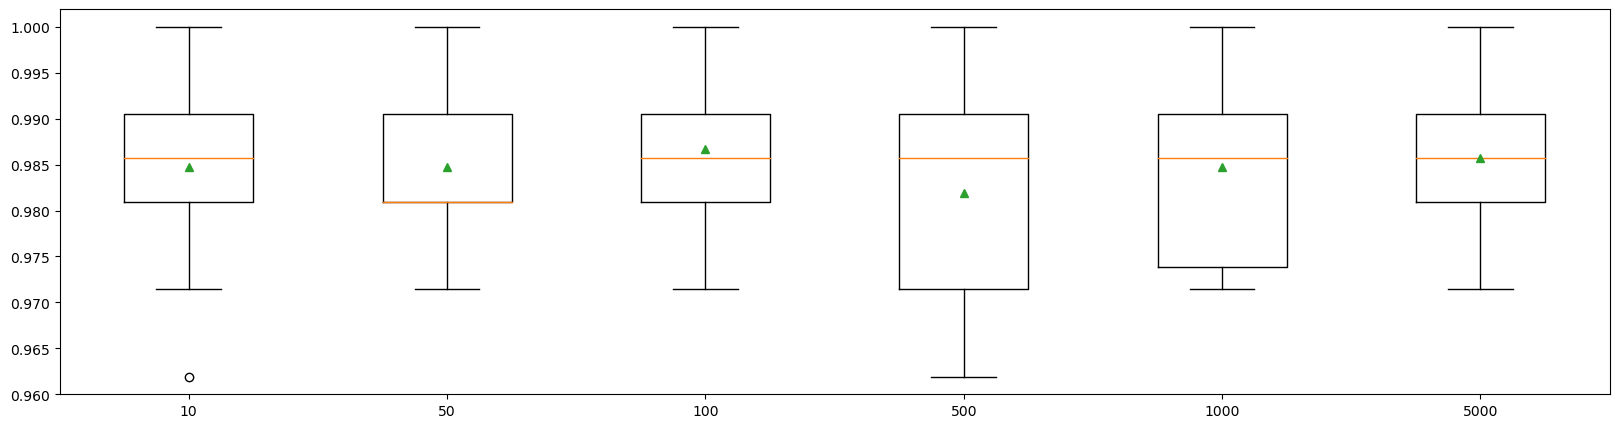

In [53]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 500, 1000, 5000]
    for n in n_trees:
        models[str(n)] = BaggingClassifier()
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X_train, Y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, Y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores*100), std(scores)))

# plot model performance for comparison
plt.figure(figsize=(20,5))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [54]:
model

BaggingClassifier()

In [55]:
clf_bagging = BaggingClassifier(n_estimators=100)
clf_bagging.fit(X_train , Y_train)
Y_pred_bagging = clf_bagging.predict(X_test)
Y_pred_train_bagging = clf_bagging.predict(X_train)

In [56]:
model = "Bagging Classifier"

accuracy_train = metrics.accuracy_score(Y_train, Y_pred_train_bagging)*100
print("Accuracy_train:", accuracy_train)
accuracy_test = metrics.accuracy_score(Y_test, Y_pred_bagging)*100
print("Accuracy_test:", accuracy_test)
f1 = f1_score(Y_test, Y_pred_bagging)
auc = roc_auc_score(Y_test, Y_pred_bagging)
print("ROC_AUC:", auc)
print(confusion_matrix(Y_test, Y_pred_bagging))
print(classification_report(Y_test, Y_pred_bagging))

Accuracy_train: 100.0
Accuracy_test: 98.44444444444444
ROC_AUC: 0.9799999999999999
[[145   5]
 [  2 298]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       0.98      0.99      0.99       300

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [57]:
results_df = results_df.append({'Model': model, 'Accuracy_train': accuracy_train, 'Accuracy_test': accuracy_test, 
                                'F1_Score': f1*100, 'ROC_AUC': auc*100}, ignore_index=True)
results_df

,Model,Accuracy_train,Accuracy_test,F1_Score,ROC_AUC
0,Logistic Classifier,99.428571,98.000000,98.507463,97.500000
1,Naive Bayes,99.428571,98.444444,98.839138,98.000000
2,Support Vector Machine,99.333333,98.222222,98.675497,97.666667
3,Support Vector Machine SC,99.523810,98.222222,98.671096,97.833333
4,K-Nearest Neighbour,99.428571,98.444444,98.839138,98.000000
5,Decision Tree,99.238095,96.666667,97.495826,96.333333
6,Random Forest,99.333333,98.666667,99.006623,98.166667
7,Stacking Classifier,99.523810,98.666667,99.006623,98.166667
8,Bagging Classifier,100.000000,98.444444,98.839138,98.000000


## XGBoost Classifier

In [58]:
# grid_xgb = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 500, 1000],
#     'subsample': [0.8, 0.9, 1],
#     'colsample_bytree': [0.8, 0.9, 1],
#     'gamma': [0, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5],
#     'scale_pos_weight': [1, 10, 50]
# }

# clf_xgb = xgb.XGBClassifier()
# grid_cv_xgb = GridSearchCV(estimator=clf_xgb, 
#                            param_grid=grid_xgb,
#                            verbose=2,
#                            n_jobs=-1, 
#                            cv=5)

# grid_cv_xgb.fit(X_train, Y_train)
# print("Best score is: %f using %s" % (grid_cv_xgb.best_score_*100, 
#                                       grid_cv_xgb.best_params_))

In [59]:
model = "XGB Classifier"

clf_xgb = xgb.XGBClassifier(gamma=0,
                            subsample=1,
                            max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1, 
                            min_child_weight=1, 
                            scale_pos_weight=1,
                            colsample_bytree=0.8)

clf_xgb.fit(X_train , Y_train)
Y_pred_xgb = clf_xgb.predict(X_test)
Y_pred_train_xgb = clf_xgb.predict(X_train)

accuracy_train = metrics.accuracy_score(Y_train, Y_pred_train_xgb)*100
print("Accuracy_train:", accuracy_train)
accuracy_test = metrics.accuracy_score(Y_test, Y_pred_xgb)*100
print("Accuracy_test:", accuracy_test)
f1 = f1_score(Y_test, Y_pred_xgb)
auc = roc_auc_score(Y_test, Y_pred_xgb)
print("ROC_AUC:", auc*100)
print(confusion_matrix(Y_test, Y_pred_xgb))
print(classification_report(Y_test, Y_pred_xgb))

Accuracy_train: 99.90476190476191
Accuracy_test: 98.66666666666667
ROC_AUC: 98.16666666666667
[[145   5]
 [  1 299]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       0.98      1.00      0.99       300

    accuracy                           0.99       450
   macro avg       0.99      0.98      0.98       450
weighted avg       0.99      0.99      0.99       450



In [60]:
results_df = results_df.append({'Model': model, 'Accuracy_train': accuracy_train, 'Accuracy_test': accuracy_test, 
                                'F1_Score': f1*100, 'ROC_AUC': auc*100}, ignore_index=True)
results_df

,Model,Accuracy_train,Accuracy_test,F1_Score,ROC_AUC
0,Logistic Classifier,99.428571,98.000000,98.507463,97.500000
1,Naive Bayes,99.428571,98.444444,98.839138,98.000000
2,Support Vector Machine,99.333333,98.222222,98.675497,97.666667
3,Support Vector Machine SC,99.523810,98.222222,98.671096,97.833333
4,K-Nearest Neighbour,99.428571,98.444444,98.839138,98.000000
5,Decision Tree,99.238095,96.666667,97.495826,96.333333
6,Random Forest,99.333333,98.666667,99.006623,98.166667
7,Stacking Classifier,99.523810,98.666667,99.006623,98.166667
8,Bagging Classifier,100.000000,98.444444,98.839138,98.000000
9,XGB Classifier,99.904762,98.666667,99.006623,98.166667


## Neural Network

In [61]:
# # Multi Layer Perceptron 
# param_mlp = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
#     'activation': ['logistic', 'tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.001, 0.01],
#     'learning_rate': ['constant', 'adaptive']
# }

# clf_mlp = MLPClassifier(random_state=0)
# grid_cv_mlp = GridSearchCV(clf_mlp, param_mlp, cv=5, verbose=2, n_jobs=-1)

# grid_cv_mlp.fit(X_train, Y_train)
# print("Best score is: %f using %s" % (grid_cv_mlp.best_score_*100, 
#                                       grid_cv_mlp.best_params_))

In [62]:
model = "MLP Classifier"

clf_mlp = MLPClassifier(activation='tanh',
                        alpha=0.0001,
                        hidden_layer_sizes=(50, 50),
                        learning_rate='constant', 
                        solver='adam')
clf_mlp.fit(X_train , Y_train)
Y_pred_mlp = clf_mlp.predict(X_test)
Y_pred_train_mlp = clf_mlp.predict(X_train)

accuracy_train = metrics.accuracy_score(Y_train, Y_pred_train_mlp)*100
print("Accuracy_train:", accuracy_train)
accuracy_test = metrics.accuracy_score(Y_test, Y_pred_mlp)*100
print("Accuracy_test:", accuracy_test)
f1 = f1_score(Y_test, Y_pred_mlp)
auc = roc_auc_score(Y_test, Y_pred_mlp)
print("ROC_AUC:", auc*100)
print(confusion_matrix(Y_test, Y_pred_mlp))
print(classification_report(Y_test, Y_pred_mlp))

Accuracy_train: 99.04761904761905
Accuracy_test: 98.0
ROC_AUC: 97.5
[[144   6]
 [  3 297]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       150
           1       0.98      0.99      0.99       300

    accuracy                           0.98       450
   macro avg       0.98      0.97      0.98       450
weighted avg       0.98      0.98      0.98       450



In [63]:
results_df = results_df.append({'Model': model, 'Accuracy_train': accuracy_train, 'Accuracy_test': accuracy_test, 
                                'F1_Score': f1*100, 'ROC_AUC': auc*100}, ignore_index=True)
results_df

,Model,Accuracy_train,Accuracy_test,F1_Score,ROC_AUC
0,Logistic Classifier,99.428571,98.000000,98.507463,97.500000
1,Naive Bayes,99.428571,98.444444,98.839138,98.000000
2,Support Vector Machine,99.333333,98.222222,98.675497,97.666667
3,Support Vector Machine SC,99.523810,98.222222,98.671096,97.833333
4,K-Nearest Neighbour,99.428571,98.444444,98.839138,98.000000
5,Decision Tree,99.238095,96.666667,97.495826,96.333333
6,Random Forest,99.333333,98.666667,99.006623,98.166667
7,Stacking Classifier,99.523810,98.666667,99.006623,98.166667
8,Bagging Classifier,100.000000,98.444444,98.839138,98.000000
9,XGB Classifier,99.904762,98.666667,99.006623,98.166667


In [64]:
model_1 = Sequential()
model_1.add(Dense(128, input_dim=X.shape[1],  activation='relu')) #1st layer
model_1.add(Dense(64, activation='relu')) #2nd layer
model_1.add(Dense(32, activation='relu')) #2nd layer
model_1.add(Dense(16, activation='relu')) #3nd layer
model_1.add(Dense(1, activation='sigmoid')) #4rd layer or output layer

model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11,777
Trainable params: 11,777
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model_1.fit(X_train, Y_train, validation_split=0.33, epochs=50, batch_size=64, verbose=0)

scores = model_1.evaluate(X_test, Y_test)
print("%s: %.2f%%" % (model_1.metrics_names[1], scores[1]*100))

15/15 [==============================] - 0s 601us/step - loss: 0.3017 - accuracy: 0.9756
accuracy: 97.56%


In [66]:
# predict probabilities for test set
Y_pred_probs = model_1.predict(X_test, verbose=0)
# predict crisp classes for test set
Y_pred_classes = (model_1.predict(X_test) > 0.5).astype("int32")

# # accuracy: (tp + tn) / (p + n)
# accuracy = accuracy_score(Y_test, Y_pred_classes)
# print('Accuracy: %f' % accuracy)
# # precision tp / (tp + fp)
# precision = precision_score(Y_test, Y_pred_classes)
# print('Precision: %f' % precision)
# # recall: tp / (tp + fn)
# recall = recall_score(Y_test, Y_pred_classes)
# print('Recall: %f' % recall)
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(Y_test, Y_pred_classes)
# print('F1 score: %f' % f1)
# # ROC AUC
# auc = roc_auc_score(Y_test, Y_pred_probs)
# print('ROC AUC: %f' % auc)
# # confusion matrix
# matrix = confusion_matrix(Y_test, Y_pred_classes)
# print(matrix)

15/15 [==============================] - 0s 1ms/step


In [67]:
model = "Neural Network"

loss_train, accuracy_train = model_1.evaluate(X_train, Y_train, verbose=0)
print("Accuracy_train:", accuracy_train*100)
loss_test, accuracy_test = model_1.evaluate(X_test, Y_test, verbose=0)
print("Accuracy_test:", accuracy_test*100)
f1 = f1_score(Y_test, Y_pred_classes)
auc = roc_auc_score(Y_test, Y_pred_classes)
print("ROC_AUC:", auc*100)
print(confusion_matrix(Y_test, Y_pred_classes))
print(classification_report(Y_test, Y_pred_classes))

Accuracy_train: 96.66666388511658
Accuracy_test: 97.55555391311646
ROC_AUC: 96.33333333333333
[[139  11]
 [  0 300]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       150
           1       0.96      1.00      0.98       300

    accuracy                           0.98       450
   macro avg       0.98      0.96      0.97       450
weighted avg       0.98      0.98      0.98       450



In [68]:
results_df = results_df.append({'Model': model, 'Accuracy_train': accuracy_train*100, 'Accuracy_test': accuracy_test*100, 
                                'F1_Score': f1*100, 'ROC_AUC': auc*100}, ignore_index=True)
results_df

,Model,Accuracy_train,Accuracy_test,F1_Score,ROC_AUC
0,Logistic Classifier,99.428571,98.000000,98.507463,97.500000
1,Naive Bayes,99.428571,98.444444,98.839138,98.000000
2,Support Vector Machine,99.333333,98.222222,98.675497,97.666667
3,Support Vector Machine SC,99.523810,98.222222,98.671096,97.833333
4,K-Nearest Neighbour,99.428571,98.444444,98.839138,98.000000
5,Decision Tree,99.238095,96.666667,97.495826,96.333333
6,Random Forest,99.333333,98.666667,99.006623,98.166667
7,Stacking Classifier,99.523810,98.666667,99.006623,98.166667
8,Bagging Classifier,100.000000,98.444444,98.839138,98.000000
9,XGB Classifier,99.904762,98.666667,99.006623,98.166667


In [69]:
results_df.sort_values('Accuracy_test', ascending=False)

,Model,Accuracy_train,Accuracy_test,F1_Score,ROC_AUC
6,Random Forest,99.333333,98.666667,99.006623,98.166667
7,Stacking Classifier,99.523810,98.666667,99.006623,98.166667
9,XGB Classifier,99.904762,98.666667,99.006623,98.166667
1,Naive Bayes,99.428571,98.444444,98.839138,98.000000
4,K-Nearest Neighbour,99.428571,98.444444,98.839138,98.000000
8,Bagging Classifier,100.000000,98.444444,98.839138,98.000000
2,Support Vector Machine,99.333333,98.222222,98.675497,97.666667
3,Support Vector Machine SC,99.523810,98.222222,98.671096,97.833333
0,Logistic Classifier,99.428571,98.000000,98.507463,97.500000
10,MLP Classifier,99.047619,98.000000,98.507463,97.500000


If we observe all the ensemble methids are doing good with high accuracy

# Final Model

In [70]:
#XGB Classifier
clf_final_xgb = xgb.XGBClassifier(gamma=0,
                                  subsample=1,
                                  max_depth=3,
                                  n_estimators=100,
                                  learning_rate=0.1, 
                                  min_child_weight=1, 
                                  scale_pos_weight=1,
                                  colsample_bytree=0.8)
clf_final_xgb.fit(X, Y)
Y_pred_final_xgb = clf_final_xgb.predict(X)
print("XGBoost training accuracy:", metrics.accuracy_score(Y, Y_pred_final_xgb)*100)

#Stacking Classifier
clf_stacking.fit(X, Y)
Y_pred_final_stack = clf_stacking.predict(X)
print("Stacking training accuracy:", metrics.accuracy_score(Y, Y_pred_final_stack)*100)

#Random Forest Classifier
clf_final_rf = RandomForestClassifier(criterion='gini', 
                                      max_depth=4, 
                                      min_samples_leaf=1, 
                                      min_samples_split=5, 
                                      n_estimators=100, 
                                      max_features= 'sqrt')
clf_final_rf.fit(X_train , Y_train)
Y_pred_final_rf = clf_final_rf.predict(X)
print("Random Forest training accuracy:", metrics.accuracy_score(Y, Y_pred_final_rf)*100)

XGBoost training accuracy: 99.93333333333332
Stacking training accuracy: 99.26666666666667
Random Forest training accuracy: 99.2


In [71]:
import pickle
from pickle import dump
from pickle import load

In [72]:
filename = 'finalized_model_xgb.sav'
pickle.dump(clf_final_xgb, open(filename, 'wb'))

In [73]:
filename = 'finalized_model_rf.sav'
pickle.dump(clf_final_rf, open(filename, 'wb'))

In [76]:
#with open('model_xgb.pkl', 'rb') as f:
#     model = pickle.load(f)